## Student Identity
Name: Arman Lotfalikhani <br>
Student Number: 99109166

In [1]:
import torch
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader

import numpy as np
from matplotlib import pyplot as plt
from typing import Dict

In [2]:
train_set = MNIST(root='.', train=True, download=True, transform=transforms.ToTensor())
test_set = MNIST(root='.', train=False, download=True, transform=transforms.ToTensor())
num_classes = len(MNIST.classes)
print(num_classes)

10


In [3]:
train_loader = DataLoader(train_set, 50000, shuffle=True)
test_loader = DataLoader(test_set, 10000, shuffle=True)

### Mask_Creator
In the following cell, in addition to the previously-defined FFLayer and FFNet, a new class named Mask_Creator is defined and used. <br>
Initialization: In the paper, it was proposed that after generating a random mask, we use a filter $[1/4, 1/2, 1/4]$ and convolve it horizontally and verticaly multiple times, and then put a 0.5 threshold on the output. So we define W and WT (W-transpose), and added new dimensions to it (its shape is $[1,1,1,3]$)to avoid errors. <br>
The reason for its inheritance from nn.Module is only to hint that it is intended for PyTorch tensors, and hence a forward method was created. But the main functionality in through mask().

### Masking the dataset
In the paper, it was advised that we combine two valid images by coefficients of mask and 1-mask. This is implemented inside the train function. For each minibatch, the data are shuffled randomly by using a torch.randperm function and are then combined with the original data with the mentioned coefficients

In [4]:
import torch.nn as nn
import torch.nn.functional as F
import time
class FFLayer(nn.Module):
    def __init__(self, epsilon, in_dim, out_dim, threshold, lr, device='cpu',dtype=torch.float32):
        super().__init__()
        self.layer=nn.Sequential(
            nn.Linear(in_features=in_dim, out_features=out_dim, bias=True, device=device, dtype=dtype),
            nn.ReLU()
        )
        
        self.threshold=threshold
        self.device=device
        self.dtype=dtype
        self.optimizer=torch.optim.Adam(self.parameters(),lr)

    def forward(self, x):
        x_normalized = x / (x.norm(2, 1, keepdim=True) + 1e-5)
        return self.layer(x_normalized)
    
    def optimizer_step(self, x_pos,x_neg):
        pos_f=self.forward(x_pos)
        neg_f=self.forward(x_neg)
        goodness_pos=torch.square(pos_f).mean(1)
        goodness_neg=torch.square(neg_f).mean(1)

        loss=torch.log(1+ torch.cat([torch.exp(-goodness_pos+self.threshold),
                                    torch.exp(goodness_neg-self.threshold)] ) ).mean()        
        loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()
        return loss
    
class Mask_Creator(nn.Module):
    def __init__(self, n, device='cpu',dtype=torch.float32):
        super().__init__()
        self.W=torch.tensor([[1/4, 1/2, 1/4]]).to(device).type(dtype)
        self.W=self.W[None, None, :]
        self.WT=torch.transpose(self.W,2,3)
        self.n=n
        self.device=device
        self.dtype=dtype
    
    def mask(self, input_tensor):
        rand_vs=torch.rand(input_tensor.size()).to(self.device).type(self.dtype)
        out =self.forward(rand_vs)
        return out
    
    def forward(self, x): #Implemented beacuse of inheritance from nn.Module
        y=x.clone()
        for i in range(self.n):
            y=F.conv2d(y, self.W, bias=None, stride=1, padding='same', dilation=1, groups=1)
            y=F.conv2d(y, self.WT, bias=None, stride=1, padding='same', dilation=1, groups=1)
        y=torch.sign(F.relu(y-0.5)) #A trick for heaviside function without casting do device and type issues
        return y


class FFNet():
    def __init__(self,epsilon, dims, n_mask, threshold_list, lr, device='cpu',dtype=torch.float32):
        '''Note: threshold_list must have size L and dims must have the size L+1. L: number of layers'''
        super().__init__()
        self.layers=[]
        self.device=device
        self.mask_c=Mask_Creator(n_mask, device=device, dtype=dtype)
        for i in range(len(dims)-1):
            self.layers.append(FFLayer(epsilon, in_dim=dims[i], out_dim=dims[i+1], device=device, 
                                       dtype=dtype, threshold=threshold_list[i], lr=lr))
        print(self.layers)
    def train(self, num_epochs, train_dataloader):
        data=None
        for i,train in enumerate(train_dataloader,0):
            data=train
        L=len(self.layers)
        for l in range(L):
            print('Training layer: ',l+1)
            for epoch in range(num_epochs):
                running_loss= 0.0
                
                images=data[0].to(self.device)
                
                indices=torch.randperm(images.size(0))
                false_images=images[indices]
                mask=self.mask_c.mask(images)
                
                neg_images=torch.mul(mask,images)+torch.mul(1-mask, false_images)

                images=torch.flatten(images,start_dim=1)/torch.max(images) #Scale between zero and one
                neg_images=torch.flatten(neg_images,start_dim=1)/torch.max(images) #Scale between zero and one
                
                pos_data=self.forward_for_layer( l,images )
                neg_data=self.forward_for_layer( l, neg_images)

                running_loss+= self.layers[l].optimizer_step(pos_data,neg_data)
                running_loss_mean=running_loss
                if (epoch+1)%20==0:
                    print("Epoch: %i Running loss: %f"%(epoch+1, running_loss_mean))
                    
    def forward_for_layer(self,i,x): #Forwards the data for layer i in the training process
        y=x.clone()
        with torch.no_grad():
            for j in range(i):
                y=self.layers[j].forward(y)
        return y.detach()


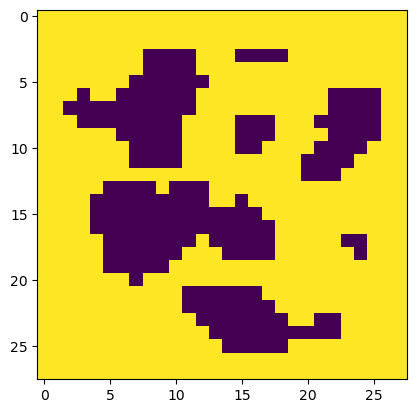

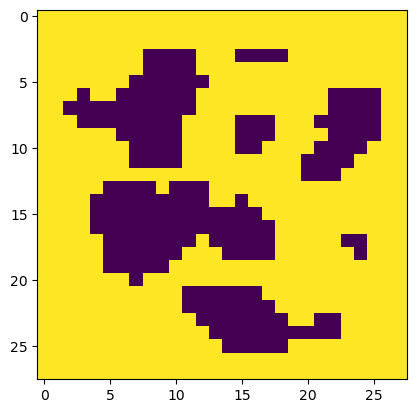

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mask=Mask_Creator(5, device=device, dtype=torch.float32)
x_train, y_train = next(iter(train_loader))
x_train, y_train = x_train.to(device), y_train.to(device)
masked=mask.mask(x_train)
sample=1-masked[100][0]
plt.imshow(sample.detach().cpu().numpy())

In [6]:
net=FFNet(epsilon=1e-2,dims=[784,400,300],n_mask=5, device=device,dtype=torch.float32, threshold_list=[3, 4], lr=0.01)
net.train(600, train_loader)

[FFLayer(
  (layer): Sequential(
    (0): Linear(in_features=784, out_features=400, bias=True)
    (1): ReLU()
  )
), FFLayer(
  (layer): Sequential(
    (0): Linear(in_features=400, out_features=300, bias=True)
    (1): ReLU()
  )
)]
Training layer:  1
Epoch: 20 Running loss: 0.870259
Epoch: 40 Running loss: 0.728929
Epoch: 60 Running loss: 0.725497
Epoch: 80 Running loss: 0.721813
Epoch: 100 Running loss: 0.722260
Epoch: 120 Running loss: 0.719738
Epoch: 140 Running loss: 0.715848
Epoch: 160 Running loss: 0.711935
Epoch: 180 Running loss: 0.706214
Epoch: 200 Running loss: 0.698745
Epoch: 220 Running loss: 0.688208
Epoch: 240 Running loss: 0.676141
Epoch: 260 Running loss: 0.668215
Epoch: 280 Running loss: 0.659497
Epoch: 300 Running loss: 0.648927
Epoch: 320 Running loss: 0.638171
Epoch: 340 Running loss: 0.626269
Epoch: 360 Running loss: 0.610086
Epoch: 380 Running loss: 0.596550
Epoch: 400 Running loss: 0.583675
Epoch: 420 Running loss: 0.572488
Epoch: 440 Running loss: 0.560689
Ep

### Linear classifier <br>
For evaluating the unsupervised layers, we need another supervised layer to see if the extracted features were good enough.

The structure of the Linear_Classifier class is similar to the previous neural net structures, with a batch normalization layer before the linear layer and with a crossentropy loss. Also, the prediction function is fully vectorized.

In [7]:
class Linear_classifier(nn.Module):
    def __init__(self, epsilon, in_dim, num_classes, lr, device='cpu',dtype=torch.float32):
        super().__init__() 
        self.layer = nn.Sequential(
            nn.BatchNorm1d(num_features=in_dim,eps=epsilon,affine=False, device=device, dtype=dtype),
            nn.Linear(in_features=in_dim, out_features=num_classes, bias=True, device=device, dtype=dtype)
        ) 
        self.device=device
        self.dtype=dtype
        self.optimizer=torch.optim.Adam(self.parameters(),lr)

    def forward(self, X):
        out= self.layer(X)
        return out
    
    def train(self, X,y,num_epochs):
        for epoch in range(num_epochs):
            running_loss= self.optimizer_step(self.forward(X),y)
            if (epoch+1)%5==0:
                print("Epoch: %i Running loss: %f"%(epoch+1, running_loss))
        return
    
    def optimizer_step(self, X,y):
        loss_f=nn.CrossEntropyLoss()
        loss=loss_f(X,y)
        loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()
        return loss
    
    def predict(self, X_test, y_test):
        with torch.no_grad():
            predictions=torch.argmax(self.forward(X_test),1)
            correct=torch.sum(torch.eq(predictions,y_test)).item()
            total=len(predictions)
        return correct,total

In [8]:
lin=Linear_classifier(epsilon=1e-2, in_dim=300, num_classes=10, lr=0.01, device=device,dtype=torch.float32)
images=torch.flatten(x_train,start_dim=1)
x_out=net.forward_for_layer(2,images)
lin.train(x_out,y_train,80)

Epoch: 5 Running loss: 1.134810
Epoch: 10 Running loss: 1.124351
Epoch: 15 Running loss: 1.056410
Epoch: 20 Running loss: 0.968943
Epoch: 25 Running loss: 0.898531
Epoch: 30 Running loss: 0.875756
Epoch: 35 Running loss: 0.859196
Epoch: 40 Running loss: 0.836450
Epoch: 45 Running loss: 0.823473
Epoch: 50 Running loss: 0.812089
Epoch: 55 Running loss: 0.801607
Epoch: 60 Running loss: 0.793118
Epoch: 65 Running loss: 0.784976
Epoch: 70 Running loss: 0.777676
Epoch: 75 Running loss: 0.770905
Epoch: 80 Running loss: 0.764637


In [9]:
train_images=torch.flatten(x_train,start_dim=1)
x_train_out=net.forward_for_layer(2,train_images)
train_true,train_tot=lin.predict(x_train_out,y_train)
print('True: ', train_true, 'Total: ', train_tot, 'Error= ', 1-train_true/train_tot)

True:  37126 Total:  50000 Error=  0.25748000000000004


In [10]:
x_test, y_test = next(iter(test_loader))
x_test, y_test = x_test.cuda(), y_test.cuda()
test_images=torch.flatten(x_test,start_dim=1)
x_test_out=net.forward_for_layer(2,test_images)
test_true,test_tot=lin.predict(x_test_out,y_test)
print('True: ', test_true, 'Total: ', test_tot, 'Error= ', 1-test_true/test_tot)

True:  7450 Total:  10000 Error=  0.255


### Result report: <br>
It is clear the model is working properly, as the accuracies are decent and far from the truly-random-10%. In the next cells,
we try to change some hyperparameters to get a better accuracy.

In [11]:
net2=FFNet(epsilon=1e-2,dims=[784,400,300],n_mask=5, device=device,dtype=torch.float32, threshold_list=[3, 3], lr=0.01)
net2.train(600, train_loader)

[FFLayer(
  (layer): Sequential(
    (0): Linear(in_features=784, out_features=400, bias=True)
    (1): ReLU()
  )
), FFLayer(
  (layer): Sequential(
    (0): Linear(in_features=400, out_features=300, bias=True)
    (1): ReLU()
  )
)]
Training layer:  1
Epoch: 20 Running loss: 0.866091
Epoch: 40 Running loss: 0.730599
Epoch: 60 Running loss: 0.726306
Epoch: 80 Running loss: 0.721734
Epoch: 100 Running loss: 0.722137
Epoch: 120 Running loss: 0.722335
Epoch: 140 Running loss: 0.716773
Epoch: 160 Running loss: 0.714428
Epoch: 180 Running loss: 0.711641
Epoch: 200 Running loss: 0.702202
Epoch: 220 Running loss: 0.693829
Epoch: 240 Running loss: 0.682171
Epoch: 260 Running loss: 0.669948
Epoch: 280 Running loss: 0.659766
Epoch: 300 Running loss: 0.648780
Epoch: 320 Running loss: 0.635694
Epoch: 340 Running loss: 0.627252
Epoch: 360 Running loss: 0.609477
Epoch: 380 Running loss: 0.597045
Epoch: 400 Running loss: 0.581158
Epoch: 420 Running loss: 0.569634
Epoch: 440 Running loss: 0.560789
Ep

In [22]:
lin2=Linear_classifier(epsilon=1e-2, in_dim=300, num_classes=10, lr=0.02, device=device,dtype=torch.float32)
x_out2=net2.forward_for_layer(2,images)
lin2.train(x_out2,y_train,200)

Epoch: 5 Running loss: 1.391962
Epoch: 10 Running loss: 1.325142
Epoch: 15 Running loss: 1.137025
Epoch: 20 Running loss: 0.972278
Epoch: 25 Running loss: 0.920268
Epoch: 30 Running loss: 0.857546
Epoch: 35 Running loss: 0.830808
Epoch: 40 Running loss: 0.789159
Epoch: 45 Running loss: 0.772138
Epoch: 50 Running loss: 0.752636
Epoch: 55 Running loss: 0.742367
Epoch: 60 Running loss: 0.729108
Epoch: 65 Running loss: 0.720158
Epoch: 70 Running loss: 0.711395
Epoch: 75 Running loss: 0.704156
Epoch: 80 Running loss: 0.697398
Epoch: 85 Running loss: 0.691278
Epoch: 90 Running loss: 0.685658
Epoch: 95 Running loss: 0.680356
Epoch: 100 Running loss: 0.675428
Epoch: 105 Running loss: 0.670777
Epoch: 110 Running loss: 0.666381
Epoch: 115 Running loss: 0.662213
Epoch: 120 Running loss: 0.658248
Epoch: 125 Running loss: 0.654466
Epoch: 130 Running loss: 0.650855
Epoch: 135 Running loss: 0.647396
Epoch: 140 Running loss: 0.644081
Epoch: 145 Running loss: 0.640897
Epoch: 150 Running loss: 0.637836


In [23]:
train_images=torch.flatten(x_train,start_dim=1)
x_train_out2=net2.forward_for_layer(2,train_images)
train_true2,train_tot2=lin2.predict(x_train_out2,y_train)
print('True: ', train_true2, 'Total: ', train_tot2, 'Error= ', 1-train_true2/train_tot2)

True:  39881 Total:  50000 Error=  0.20238


In [24]:
x_test_out2=net2.forward_for_layer(2,test_images)
test_true2,test_tot2=lin2.predict(x_test_out2,y_test)
print('True: ', test_true2, 'Total: ', test_tot2, 'Error= ', 1-test_true2/test_tot2)

True:  7949 Total:  10000 Error=  0.20509999999999995


### Hyperparameter setting 2

In [25]:
net3=FFNet(epsilon=1e-2,dims=[784,600,500],n_mask=5, device=device,dtype=torch.float32, threshold_list=[3, 2], lr=0.01)
net3.train(900, train_loader)

[FFLayer(
  (layer): Sequential(
    (0): Linear(in_features=784, out_features=600, bias=True)
    (1): ReLU()
  )
), FFLayer(
  (layer): Sequential(
    (0): Linear(in_features=600, out_features=500, bias=True)
    (1): ReLU()
  )
)]
Training layer:  1
Epoch: 20 Running loss: 0.866596
Epoch: 40 Running loss: 0.729178
Epoch: 60 Running loss: 0.726352
Epoch: 80 Running loss: 0.723812
Epoch: 100 Running loss: 0.721892
Epoch: 120 Running loss: 0.719372
Epoch: 140 Running loss: 0.716927
Epoch: 160 Running loss: 0.712716
Epoch: 180 Running loss: 0.708165
Epoch: 200 Running loss: 0.701409
Epoch: 220 Running loss: 0.690713
Epoch: 240 Running loss: 0.678835
Epoch: 260 Running loss: 0.669115
Epoch: 280 Running loss: 0.657919
Epoch: 300 Running loss: 0.646604
Epoch: 320 Running loss: 0.632589
Epoch: 340 Running loss: 0.620640
Epoch: 360 Running loss: 0.603008
Epoch: 380 Running loss: 0.590280
Epoch: 400 Running loss: 0.575999
Epoch: 420 Running loss: 0.567671
Epoch: 440 Running loss: 0.560697
Ep

In [27]:
lin3=Linear_classifier(epsilon=1e-2, in_dim=500, num_classes=10, lr=0.02, device=device,dtype=torch.float32)
x_out3=net3.forward_for_layer(2,images)
lin3.train(x_out3,y_train,200)

Epoch: 5 Running loss: 1.287718
Epoch: 10 Running loss: 1.174330
Epoch: 15 Running loss: 0.955891
Epoch: 20 Running loss: 0.793940
Epoch: 25 Running loss: 0.685191
Epoch: 30 Running loss: 0.614353
Epoch: 35 Running loss: 0.558119
Epoch: 40 Running loss: 0.519524
Epoch: 45 Running loss: 0.492863
Epoch: 50 Running loss: 0.477686
Epoch: 55 Running loss: 0.462478
Epoch: 60 Running loss: 0.452165
Epoch: 65 Running loss: 0.446103
Epoch: 70 Running loss: 0.439405
Epoch: 75 Running loss: 0.434220
Epoch: 80 Running loss: 0.429872
Epoch: 85 Running loss: 0.426118
Epoch: 90 Running loss: 0.422612
Epoch: 95 Running loss: 0.419438
Epoch: 100 Running loss: 0.416440
Epoch: 105 Running loss: 0.413651
Epoch: 110 Running loss: 0.411015
Epoch: 115 Running loss: 0.408521
Epoch: 120 Running loss: 0.406144
Epoch: 125 Running loss: 0.403878
Epoch: 130 Running loss: 0.401710
Epoch: 135 Running loss: 0.399633
Epoch: 140 Running loss: 0.397638
Epoch: 145 Running loss: 0.395722
Epoch: 150 Running loss: 0.393876


In [28]:
x_train_out3=net3.forward_for_layer(2,train_images)
train_true3,train_tot3=lin3.predict(x_train_out3,y_train)
print('True: ', train_true3, 'Total: ', train_tot3, 'Error= ', 1-train_true3/train_tot3)

True:  43735 Total:  50000 Error=  0.12529999999999997


In [29]:
x_test_out3=net3.forward_for_layer(2,test_images)
test_true3,test_tot3=lin3.predict(x_test_out3,y_test)
print('True: ', test_true3, 'Total: ', test_tot3, 'Error= ', 1-test_true3/test_tot3)

True:  8744 Total:  10000 Error=  0.12560000000000004


### Result report 2 <br>
It appears that just by increasing the training epochs on the last linear classifier, we can achieve a 80% accuracy on both the train set and the test set.

Also, by changing th neuron sizes to 600 and 500, we were able to achieve an accuracy of 87.5%